# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Load the dataset.

In [3]:
# Load and unzip the dataset
import os
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')
# Path to your ZIP file
zip_path = '/content/drive/My Drive/data.zip'
extract_path = '/content/'  # Destination folder

# Unzip the dataset
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset extracted to '{extract_path}'")
else:
    print("❌ File 'data.zip' not found. Make sure it's in the current directory.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted to '/content/'


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
import os
from PIL import Image
import numpy as np

def load_images_from_folder(data_dir, image_size=(128, 128)):
    import os
    from PIL import Image
    import numpy as np

    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_to_label = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # ✅ Check if it's a file (not a subdirectory)
            if not os.path.isfile(img_path):
                continue

            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img)

                images.append(img_array)
                labels.append(class_to_label[class_name])
            except Exception as e:
                print(f"❌ Failed to load image: {img_path} – {e}")

    images = np.array(images)
    labels = np.array(labels)

    print(f"✅ Loaded {len(images)} images from {len(class_names)} classes.")
    return images, labels, class_names



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels
# Define the path to the extracted dataset
data_dir = '/content/data'  # Change if your folder name is different

# Load images and labels
X, y, class_names = load_images_from_folder(data_dir, image_size=(128, 128))


✅ Loaded 7625 images from 7 classes.


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [6]:
# Visualise Data Distribution
# Count the number of samples in each class
unique, counts = np.unique(y, return_counts=True)
data = pd.DataFrame({
    'Category': [class_names[i] for i in unique],
    'Count': counts
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Category', y='Count', hue='Category', palette='viridis', legend=False)

plt.title('Class Distribution of Waste Categories')
plt.xlabel('Waste Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

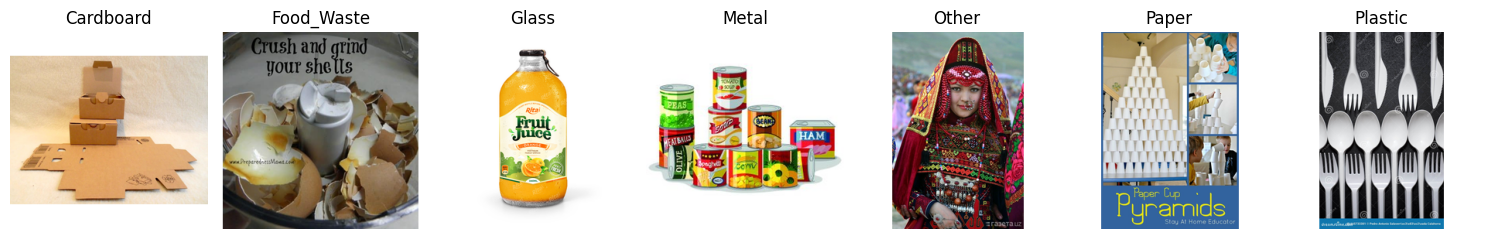

In [24]:
# Visualise Sample Images (across different labels)
# Number of samples to display
num_samples = 7

# Create a subplot grid (2 rows, num_samples columns)
plt.figure(figsize=(15, 10))

# Loop through a few random classes and display samples
for i, class_name in enumerate(class_names[:num_samples]):
    class_idx = i  # This corresponds to the label of the current class
    class_images = X[y == class_idx]  # Get images for this class

    # Randomly select one image from the class
    random_img = class_images[np.random.randint(len(class_images))]

    # Plot the image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(random_img)
    plt.title(f"{class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set
from PIL import Image
import os

# Initialize variables to track smallest and largest dimensions
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Loop through all images and get their dimensions
data_dir = '/content/data'  # Update this to your actual data directory
class_names = sorted(os.listdir(data_dir))

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-directories

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if not os.path.isfile(img_path):
            continue  # Skip non-image files

        try:
            with Image.open(img_path) as img:
                width, height = img.size
                # Update min and max dimensions
                if width < min_width or height < min_height:
                    min_width, min_height = width, height
                if width > max_width or height > max_height:
                    max_width, max_height = width, height
        except Exception as e:
            print(f"❌ Failed to open image: {img_path} – {e}")

print(f"Smallest image dimensions: {min_width}x{min_height}")
print(f"Largest image dimensions: {max_width}x{max_height}")


Smallest image dimensions: 256x256
Largest image dimensions: 256x256


In [9]:
# Resize the image dimensions
X, y, class_names = load_images_from_folder('/content/data', image_size=(256, 256))


✅ Loaded 7625 images from 7 classes.


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Convert integer labels to one-hot encoding
y_one_hot = to_categorical(y_encoded, num_classes=len(class_names))

print(f"Encoded labels (first 5 samples): {y_encoded[:5]}")
print(f"One-hot encoded labels (first 5 samples): \n{y_one_hot[:5]}")

Encoded labels (first 5 samples): [0 0 0 0 0]
One-hot encoded labels (first 5 samples): 
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
print("✅ Image pixel values normalized to [0, 1].")


Training set size: 6100
Validation set size: 1525
✅ Image pixel values normalized to [0, 1].


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [12]:
# Build and compile the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))



# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer (softmax for multi-class classification)
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary to check the architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,399 (112.87 MB)

 Trainable params: 29,586,951 (112.87 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.3112 - loss: 2.3762 - val_accuracy: 0.1062 - val_loss: 2.9656
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5243 - loss: 1.3290 - val_accuracy: 0.3279 - val_loss: 1.8356
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.6262 - loss: 1.0583 - val_accuracy: 0.5167 - val_loss: 1.3555
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.7206 - loss: 0.8175 - val_accuracy: 0.5862 - val_loss: 1.2258
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.7864 - loss: 0.6463 - val_accuracy: 0.5961 - val_loss: 1.1971
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8338 - loss: 0.5142 - val_accuracy: 0.6184 - val_loss: 1.1806
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8743 - loss: 0.4036 - val_accuracy: 0.6216 - val_loss: 1.1560
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8978 - loss: 0.3291 -

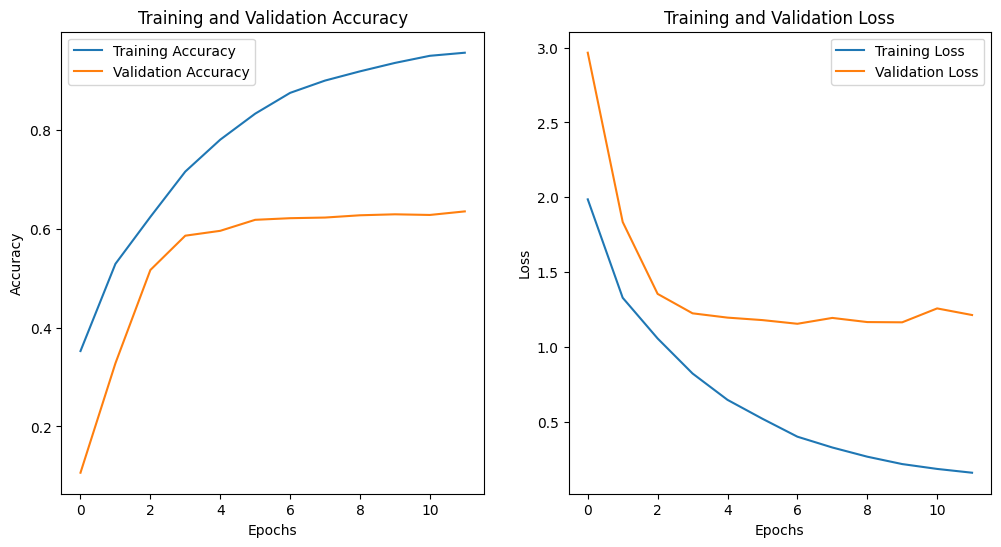

In [14]:
# Training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Saving the whole model in .keras format

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Plot the training and validation loss/accuracy
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.64      0.75      0.69       108
  Food_Waste       0.68      0.65      0.66       200
       Glass       0.59      0.55      0.57       150
       Metal       0.67      0.58      0.62       200
       Other       0.57      0.54      0.55       202
       Paper       0.50      0.49      0.50       206
     Plastic       0.66      0.72      0.69       459

    accuracy                           0.62      1525
   macro avg       0.61      0.61      0.61      1525
weighted avg       0.62      0.62      0.62      1525



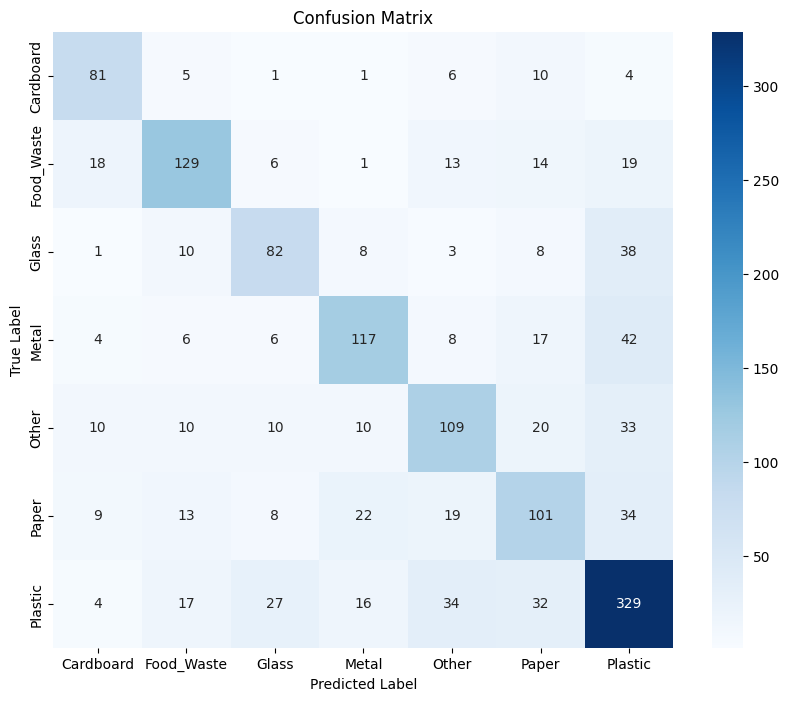

In [16]:
# Evaluate on the test set; display suitable metrics
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [17]:
# Define augmentation steps to augment images
TARGET_COUNT = 1000
print("Initial data shape:", X.shape)
print("Initial labels shape:", y.shape)

# 1. Analyze Class Distribution
unique_classes, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique_classes, counts))
print("\nInitial Class Distribution (Index: Count):")
for class_idx, count in class_counts.items():
    print(f"  {class_idx} ({class_names[class_idx]}): {count}")

# 2. Implement Undersampling for Majority Classes
X_balanced = []
y_balanced = [] # Store the original integer labels for balancing

print(f"\nUndersampling classes with more than {TARGET_COUNT} samples...")

for class_idx in unique_classes:
    class_name = class_names[class_idx]
    class_indices = np.where(y == class_idx)[0] # Get indices of images for this class
    num_samples = len(class_indices)

    if num_samples > TARGET_COUNT:
        # Undersample the majority class
        print(f"  Undersampling class '{class_name}' from {num_samples} to {TARGET_COUNT} samples.")
        # Randomly select indices up to the TARGET_COUNT
        undersample_indices = np.random.choice(
            class_indices, # Select from the indices of this class
            size=TARGET_COUNT,
            replace=False # Do not select the same image multiple times
        )
        X_balanced.extend(X[undersample_indices])
        y_balanced.extend(y[undersample_indices])
    else:
        # Keep minority and other classes as is
        print(f"  Keeping all {num_samples} samples for class '{class_name}'.")
        X_balanced.extend(X[class_indices])
        y_balanced.extend(y[class_indices])

# Convert the balanced lists back to numpy arrays
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced) # This contains the original integer labels

print("\nBalanced data shape:", X_balanced.shape)
print("Balanced labels shape:", y_balanced.shape)

# Verify the new class distribution
unique_classes_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
class_counts_balanced = dict(zip(unique_classes_balanced, counts_balanced))

print("\nBalanced Class Distribution (Index: Count):")
for class_idx, count in class_counts_balanced.items():
     print(f"  {class_idx} ({class_names[class_idx]}): {count}")

Initial data shape: (7625, 256, 256, 3)
Initial labels shape: (7625,)

Initial Class Distribution (Index: Count):
  0 (Cardboard): 540
  1 (Food_Waste): 1000
  2 (Glass): 750
  3 (Metal): 1000
  4 (Other): 1010
  5 (Paper): 1030
  6 (Plastic): 2295

Undersampling classes with more than 1000 samples...
  Keeping all 540 samples for class 'Cardboard'.
  Keeping all 1000 samples for class 'Food_Waste'.
  Keeping all 750 samples for class 'Glass'.
  Keeping all 1000 samples for class 'Metal'.
  Undersampling class 'Other' from 1010 to 1000 samples.
  Undersampling class 'Paper' from 1030 to 1000 samples.
  Undersampling class 'Plastic' from 2295 to 1000 samples.

Balanced data shape: (6290, 256, 256, 3)
Balanced labels shape: (6290,)

Balanced Class Distribution (Index: Count):
  0 (Cardboard): 540
  1 (Food_Waste): 1000
  2 (Glass): 750
  3 (Metal): 1000
  4 (Other): 1000
  5 (Paper): 1000
  6 (Plastic): 1000


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [18]:
# Create a function to augment the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [19]:
# Create the augmented training dataset
y_balanced_one_hot = to_categorical(y_balanced, num_classes=len(class_names))

# Split the balanced data
X_train_balanced, X_val_balanced, y_train_balanced_one_hot, y_val_balanced_one_hot = train_test_split(
    X_balanced,
    y_balanced_one_hot,
    test_size=0.2, # Use your desired validation split ratio
    random_state=42, # Use the same random state for reproducibility
    stratify=y_balanced # IMPORTANT: Stratify based on the original integer labels to maintain distribution
)

print("\nTraining set shape after balancing and splitting:", X_train_balanced.shape)
print("Validation set shape after balancing and splitting:", X_val_balanced.shape)

# --- Then, proceed with normalization and training ---
# Normalize pixel values to the range [0, 1]
X_train_balanced = X_train_balanced.astype('float32') / 255.0
X_val_balanced = X_val_balanced.astype('float32') / 255.0
print("\n✅ Balanced image pixel values normalized to [0, 1].")
datagen.fit(X_train_balanced)



Training set shape after balancing and splitting: (5032, 256, 256, 3)
Validation set shape after balancing and splitting: (1258, 256, 256, 3)

✅ Balanced image pixel values normalized to [0, 1].


##### **4.1.2**

Train the model on the new augmented dataset.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 73s 439ms/step - accuracy: 0.3807 - loss: 1.8320 - val_accuracy: 0.6558 - val_loss: 1.1130
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 396ms/step - accuracy: 0.3974 - loss: 1.5960 - val_accuracy: 0.6081 - val_loss: 1.1726
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 397ms/step - accuracy: 0.4216 - loss: 1.5445 - val_accuracy: 0.6256 - val_loss: 1.1575
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 62s 392ms/step - accuracy: 0.4447 - loss: 1.5291 - val_accuracy: 0.6335 - val_loss: 1.1418
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 397ms/step - accuracy: 0.4318 - loss: 1.5148 - val_accuracy: 0.6184 - val_loss: 1.1753
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 397ms/step - accuracy: 0.4679 - loss: 1.4470 - val_accuracy: 0.6224 - val_loss: 1.1149


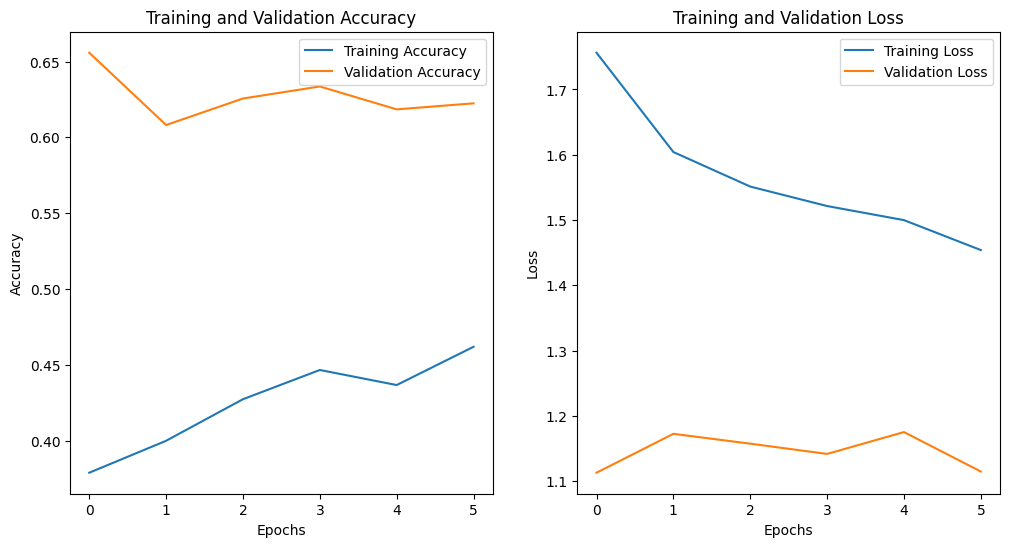

In [20]:
# Train the model using augmented images
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Saving the whole model in .keras format

history = model.fit(datagen.flow(X_train_balanced, y_train_balanced_one_hot, batch_size=32),
          validation_data=(X_val_balanced, y_val_balanced_one_hot),
          epochs=50,
          callbacks=[early_stopping, model_checkpoint])

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
y_pred_probs = model.predict(X_val_balanced)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_balanced_one_hot, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.78      0.58      0.67       108
  Food_Waste       0.58      0.73      0.65       200
       Glass       0.65      0.55      0.60       150
       Metal       0.61      0.63      0.62       200
       Other       0.74      0.70      0.72       200
       Paper       0.65      0.74      0.69       200
     Plastic       0.70      0.58      0.64       200

    accuracy                           0.66      1258
   macro avg       0.67      0.65      0.65      1258
weighted avg       0.66      0.66      0.66      1258



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

## 📊 Report on Dataset and Model

---

### 🔍 Report Your Findings About the Data

- The dataset contained **7,625 images** classified into **7 classes**.
- There was a **class imbalance**, where the **"Plastic"** class had **more than 2,000 images**, while all other classes had **1,000 or fewer**.
- All images were of dimensions **256 × 256** pixels.

---

### 🧠 CNN Model Architecture

The CNN model was built with the following components:

- **3 Convolutional Layers**
- **Normalization** and **MaxPooling** layers
- **Dropout** rate of **0.5**
- **Learning rate**: **0.00001**

---

### 📈 Report on Model Training Results

#### 📉 Results *Prior* to Data Augmentation and Handling Class Imbalance

```
              precision    recall  f1-score   support

   Cardboard       0.64      0.75      0.69       108
  Food_Waste       0.68      0.65      0.66       200
       Glass       0.59      0.55      0.57       150
       Metal       0.67      0.58      0.62       200
       Other       0.57      0.54      0.55       202
       Paper       0.50      0.49      0.50       206
     Plastic       0.66      0.72      0.69       459

    accuracy                           0.62      1525
   macro avg         0.61      0.61      0.61      1525
weighted avg       2      0.62      0.62      1525
```

---

#### 📉 Results *After* Data Augmentation and Handling Class Imbalance

```
              precision    recall  f1-score   support

   Cardboard       0.78      0.58      0.67       108
  Food_Waste       0.58      0.73      0.65       200
       Glass       0.65      0.55      0.60       150
       Metal       0.61      0.63      0.62       200
       Other       0.74      0.70      0.72       200
       Paper       0.65      0.74      0.69       200
     Plastic       0.70      0.58      0.64       200

    accuracy                           0.66      1258
   macro avg       0.67      0.65      0.65      1258ighted avg       0.66      0.66      0.66      1258
```

---
	   
         0.62      1525lassification Report:**